<a href="https://colab.research.google.com/github/emmazing394/TNM095-AI_for_interactive_media/blob/master/aidraw.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
import os
from tensorflow.keras import layers
import urllib.request
import pandas as pd


Get classes from quick draw dataset. We choose 12 animals from the 345 categories to train our model on.

In [2]:
base = 'https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/'

#classes = ["ant", "bat", "bear", "bee", "bird", "butterfly", "camel", "cat", "cow", "crab",
#          "crocodile", "dog", "dolphin", "dragon", "duck", "elephant", "fish", "flamingo", "frog",
#          "giraffe", "hedgehog", "horse", "kangaroo", "lion", "lobster", "mermaid", "monkey",
#          "mouse", "octopus", "owl", "parrot", "penguin", "pig", "rabbit", "raccoon", "rhinoceros", "scorpion", 
#          "shark", "sheep", "snail", "snake", "snowman", "spider", "squirrel", "swan", "teddy-bear", 
#           "tiger", "whale", "zebra"]

classes = ["ant", "bat", "bee", "bird", "cat", "dog", "dolphin", "fish", 
           "horse", "pig", "rabbit", "swan"]

Create direction objects 

In [3]:
!mkdir -p objects

Download classes to folder objects

In [4]:
def download():

  for c in classes:
    path = base+c+'.npy'
    print(path)
    urllib.request.urlretrieve(path, 'objects/'+ c +'.npy')


In [5]:
download()

https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/ant.npy
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/bat.npy
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/bee.npy
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/bird.npy
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/cat.npy
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/dog.npy
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/dolphin.npy
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/fish.npy
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/horse.npy
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/pig.npy
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/rabbit.npy
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/swan.npy


Load the .npy files and preprocess the data. 15000 images per class. 80% for training and 20% for testing.

In [8]:
def load_preprocess_data(path):

  #initialize variables
  x = np.empty([0, 784]) #784 columns for every object
  y = np.empty([0])
  
  #load files one by one
  files = [x for x in os.listdir(path)]

  #load to memory
  for i, file in enumerate(files):
    features = np.load(path + "/" + file)
    features = features[0:30000, :]
    labels = np.full(features.shape[0], i)

    #concatenate to create x and y datasets
    x = np.concatenate((x, features), axis=0)
    y = np.append(y, labels)

  features = None
  labels = None

  # Randomize all data
  rand = np.random.permutation(y.shape[0])
  x = x[rand, :]
  y = y[rand]
  
  test_ratio = 0.2

  #separate into training and testing
  test_size = int(x.shape[0] / 100 * (test_ratio * 100)) #20% for testing
  print(test_size)
  #testing
  x_test = x[0:test_size, :]
  y_test = y[0:test_size]

  #training
  x_train = x[test_size:x.shape[0], :]
  y_train = y[test_size:y.shape[0]]

  return x_train, y_train, x_test, y_test



In [9]:
x_train, y_train, x_test, y_test = load_preprocess_data("objects")

72000


Print some random images

Text(0.5, 1.0, 'bat')

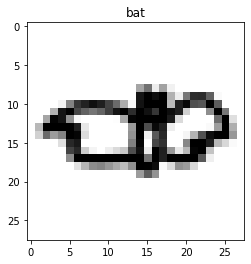

In [12]:
import matplotlib.pyplot as plt
from random import randint

idx = randint(0, len(x_train))
plt.imshow(x_train[idx].reshape(28,28), cmap="gray_r")
plt.title(classes[int(y_train[idx].item())])


In [13]:
# Reshape and normalize, image size is 28x28
#The model will take batches of the shape [N, 28, 28,1]
#Outputs probabilities of the shape [N, 10]
x_train = x_train.reshape(x_train.shape[0], 28, 28, 1).astype('float32')
x_test = x_test.reshape(x_test.shape[0], 28, 28, 1).astype('float32')

x_train /= 255.0
x_test /= 255.0

# Convert class vectors to class matrices
num_classes = 12
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

In [14]:
print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)

(288000, 28, 28, 1) (288000, 12) (72000, 28, 28, 1) (72000, 12)


In [15]:
print(x_train.shape[1:])

(28, 28, 1)


In [16]:
from keras.layers import Dense, Flatten, Conv2D
from keras.layers import MaxPooling2D, Dropout

# Define model
model = Sequential()
# input image 28x28, 3-channels
model.add(Conv2D(16, (3, 3), padding="same", input_shape=(28, 28, 1), activation="relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3), padding="same", activation= "relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3), padding="same", activation= "relu"))
model.add(MaxPooling2D(pool_size =(2,2)))

model.add(Dropout(0.2))
# flatten output of convolution from 3D to 1D
model.add(Flatten())
# hidden layer
model.add(Dense(128, activation="relu"))
# output layer
model.add(Dense(12, activation="softmax"))
#compile the model
model.compile(loss="categorical_crossentropy",
              optimizer="adam",
              metrics=["accuracy"])

print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 16)        160       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 32)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 7, 7, 64)          18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 3, 3, 64)          0         
_________________________________________________________________
dropout (Dropout)            (None, 3, 3, 64)          0

In [20]:
# Train and build the model
epochs = 10
history = model.fit(x=x_train, y=y_train, validation_split=0.1, batch_size=256, verbose=2, epochs=epochs)

Epoch 1/10
1013/1013 - 188s - loss: 0.5517 - accuracy: 0.8208 - val_loss: 0.5266 - val_accuracy: 0.8289
Epoch 2/10
1013/1013 - 189s - loss: 0.5330 - accuracy: 0.8276 - val_loss: 0.5212 - val_accuracy: 0.8313
Epoch 3/10
1013/1013 - 186s - loss: 0.5178 - accuracy: 0.8320 - val_loss: 0.5143 - val_accuracy: 0.8340
Epoch 4/10
1013/1013 - 187s - loss: 0.5059 - accuracy: 0.8352 - val_loss: 0.4970 - val_accuracy: 0.8389
Epoch 5/10
1013/1013 - 180s - loss: 0.4949 - accuracy: 0.8384 - val_loss: 0.4973 - val_accuracy: 0.8379
Epoch 6/10
1013/1013 - 185s - loss: 0.4841 - accuracy: 0.8422 - val_loss: 0.4920 - val_accuracy: 0.8390
Epoch 7/10
1013/1013 - 189s - loss: 0.4744 - accuracy: 0.8451 - val_loss: 0.4899 - val_accuracy: 0.8409
Epoch 8/10
1013/1013 - 188s - loss: 0.4676 - accuracy: 0.8470 - val_loss: 0.4947 - val_accuracy: 0.8377
Epoch 9/10
1013/1013 - 188s - loss: 0.4603 - accuracy: 0.8484 - val_loss: 0.4823 - val_accuracy: 0.8440
Epoch 10/10
1013/1013 - 185s - loss: 0.4523 - accuracy: 0.8513 -

In [21]:
score = model.evaluate(x_test, y_test, verbose=0)
print('Test accuracy: {:0.2f}%'.format(score[1]*100))

Test accuracy: 84.48%


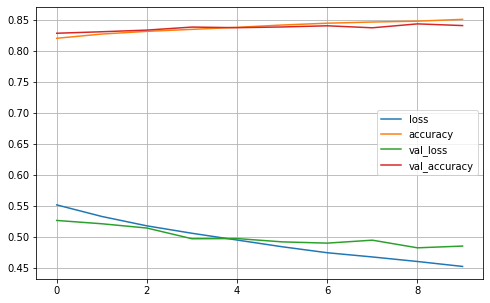

In [22]:
pd.DataFrame(history.history).plot(figsize=(8,5))
plt.grid(True)

In [24]:
pred = model.predict(x_test)
#results = model.evaluate(x_test, y_test)

print(f"After 5 epochs, the loss is {score[0]}, and the accuracy is {score[1]}")

After 5 epochs, the loss is 0.4854990243911743, and the accuracy is 0.8448055386543274


Get errors

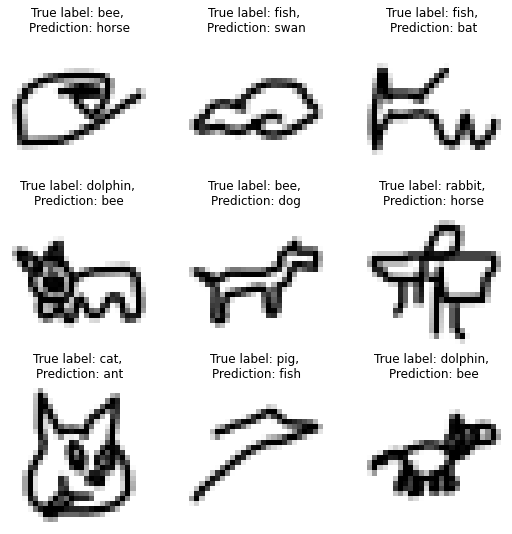

In [43]:
y_pred = np.argmax(pred, axis = 1)
y = np.argmax(y_test, axis = 1)

# Get the indices of the bad labels
bad_pred = np.argwhere((y == y_pred) == False).squeeze()

#Plot
fig, axes = plt.subplots(3, 3, figsize=(9, 9))

for i, ax in enumerate(axes.flatten()):
    idx = np.random.choice(bad_pred)
    x_show = np.squeeze(x_test[idx])
    ax.imshow(x_show, cmap="gray_r", interpolation="nearest")
    ax.set_title(f"True label: {classes[y[idx]]}, \nPrediction: {classes[y_pred[idx]]}")
    ax.axis("off")

Print top 3 predictions for a object

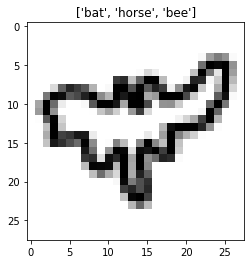

In [54]:
id_x = randint(0, len(x_test))
img = x_test[id_x]
plt.imshow(img.squeeze(), cmap="gray_r")
pred1 = model.predict(np.expand_dims(img, axis=0))[0]
ind = (-pred1).argsort()[:3]
latex = [classes[x] for x in ind]
plt.title(latex)
plt.show()

Store the classes

In [55]:
with open('classes.txt', 'w') as file_handler:
    for item in classes:
        file_handler.write("{}\n".format(item))

In [56]:
!pip install tensorflowjs

     |████████████████████████████████| 71kB 2.0MB/s 


Save and convert model

In [57]:
model.save('keras.h5')

In [58]:
!mkdir -p newmodel
!tensorflowjs_converter --input_format keras keras.h5 newmodel/

2020-11-04 15:05:28.645717: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1


Download model

In [59]:
!cp classes.txt newmodel/classes.txt

In [60]:
!zip -r newmodel.zip newmodel

  adding: newmodel/ (stored 0%)
  adding: newmodel/classes.txt (deflated 12%)
  adding: newmodel/group1-shard1of1.bin (deflated 7%)
  adding: newmodel/model.json (deflated 82%)


In [61]:
from google.colab import files 
files.download('newmodel.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>